In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [6]:
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

def orthogonal_rot(image):
    return np.rot90(image, np.random.choice([-1, 0, 1]))

image_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    channel_shift_range=50,
    preprocessing_function=orthogonal_rot
)

In [3]:
# define directories
train_dir = "/content/drive/My Drive/pneumonia/train"
val_dir = "/content/drive/My Drive/pneumonia/val"
test_dir="/content/drive/My Drive/pneumonia/test"

# Define the batch size and image size
batch_size = 32
image_size = (180, 180)

# Create datasets
train_ds = image_generator.flow_from_directory(train_dir, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               class_mode='categorical',
                                               target_size=(180, 180))
# Create datasets
val_ds = ImageDataGenerator().flow_from_directory(val_dir,
                                             batch_size=batch_size, 
                                             shuffle=False, 
                                             class_mode='categorical',
                                             target_size=(180, 180))

test_ds = ImageDataGenerator().flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 3504 images belonging to 3 classes.
Found 1169 images belonging to 3 classes.
Found 1169 images belonging to 3 classes.


In [7]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Define the CNN model architecture
def build_model(learning_rate=0.001, dropout_rate=0.2):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_size+(3,)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax')
    ])

    # Define the learning rate schedule using ExponentialDecay
    initial_learning_rate = 0.001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100,
        decay_rate=0.85,
        staircase=True
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

In [8]:
# Create the KerasClassifier wrapper for scikit-learn compatibility
keras_classifier = KerasClassifier(build_fn=build_model, verbose=1)

# Define the hyperparameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4]
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=keras_classifier, param_grid=param_grid, cv=3)

# Get the X and y from the train and validation data generators
train_X, train_y = next(train_ds)
val_X, val_y = next(val_ds)

# Fit the GridSearchCV with the generator-based training dataset
num_epochs=32
grid_search.fit(train_X, train_y, epochs=num_epochs, validation_data=(val_X, val_y), verbose=1)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters: ", best_params)

# Create the final model with the best hyperparameters
best_model = build_model(dropout_rate=best_params['dropout_rate'])

<ipython-input-8-a846703b296b>:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_classifier = KerasClassifier(build_fn=build_model, verbose=1)


Epoch 1/32
1/1 [==============================] - 3s 3s/step - loss: 2.0410 - accuracy: 0.3333 - precision_29: 0.3333 - recall_29: 0.3333 - val_loss: 649.2847 - val_accuracy: 0.0000e+00 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 2/32
1/1 [==============================] - 0s 140ms/step - loss: 3.3729 - accuracy: 0.7143 - precision_29: 0.7143 - recall_29: 0.7143 - val_loss: 1029.8629 - val_accuracy: 0.0000e+00 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 3/32
1/1 [==============================] - 0s 101ms/step - loss: 1.2849 - accuracy: 0.8571 - precision_29: 0.8571 - recall_29: 0.8571 - val_loss: 700.7531 - val_accuracy: 0.0000e+00 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 4/32
1/1 [==============================] - 0s 136ms/step - loss: 0.1320 - accuracy: 0.9048 - precision_29: 0.9048 - recall_29: 0.9048 - val_loss: 500.8680 - val_accuracy: 0.0000e+00 - val_precision_29: 0.0000e+00 - val_recall_29: 0.0000e+00
Epoch 5/32

In [ ]:
best_model.save('/content/drive/My Drive/pneumonia/CNN_tuned.h5')

In [9]:
# Fit the final model with the training dataset
history = best_model.fit(train_ds, epochs=16, validation_data=val_ds)

test_results = best_model.evaluate(test_ds)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2]
test_recall = test_results[3]

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)

Epoch 1/16
110/110 [==============================] - 714s 6s/step - loss: 1.5843 - accuracy: 0.5143 - precision_39: 0.5616 - recall_39: 0.3653 - val_loss: 1.0293 - val_accuracy: 0.4927 - val_precision_39: 0.8256 - val_recall_39: 0.0607
Epoch 2/16
110/110 [==============================] - 86s 781ms/step - loss: 0.8652 - accuracy: 0.6236 - precision_39: 0.6989 - recall_39: 0.4849 - val_loss: 5.9762 - val_accuracy: 0.2712 - val_precision_39: 0.2781 - val_recall_39: 0.2712
Epoch 3/16
110/110 [==============================] - 85s 777ms/step - loss: 0.8156 - accuracy: 0.6373 - precision_39: 0.7118 - recall_39: 0.5285 - val_loss: 1.1079 - val_accuracy: 0.5073 - val_precision_39: 0.5624 - val_recall_39: 0.2737
Epoch 4/16
110/110 [==============================] - 85s 777ms/step - loss: 0.7648 - accuracy: 0.6547 - precision_39: 0.7124 - recall_39: 0.5591 - val_loss: 0.7275 - val_accuracy: 0.6655 - val_precision_39: 0.7746 - val_recall_39: 0.5646
Epoch 5/16
110/110 [==========================

Text(0.5, 1.0, 'Accuracy Evolution')

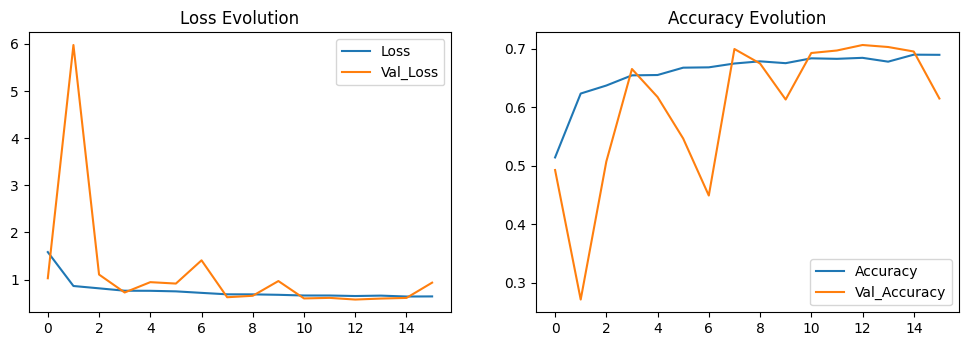

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

37/37 [==============================] - 15s 404ms/step


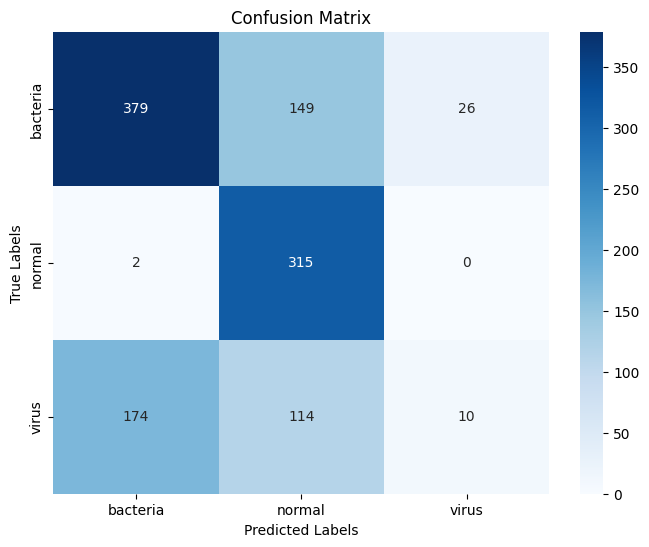

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import seaborn as sns
import numpy as np

# Generate predictions for the test set
y_pred = best_model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Obtain true labels for the test set
y_true = test_ds.classes

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_ds.class_indices, yticklabels=test_ds.class_indices)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

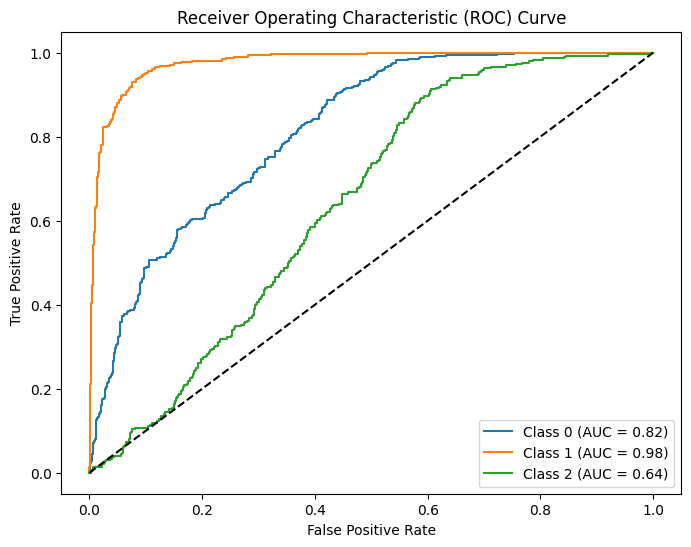

In [12]:
# Generate ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_label in range(len(test_ds.class_indices)):
    fpr[class_label], tpr[class_label], _ = roc_curve(y_true == class_label, y_pred[:, class_label])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for class_label in range(len(test_ds.class_indices)):
    plt.plot(fpr[class_label], tpr[class_label], label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

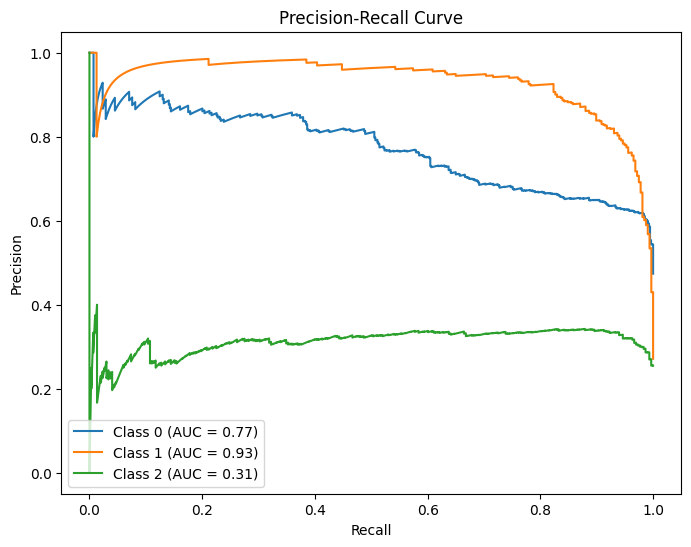

In [13]:
# Generate precision-recall curve
precision = dict()
recall = dict()
pr_auc = dict()
for class_label in range(len(test_ds.class_indices)):
    precision[class_label], recall[class_label], _ = precision_recall_curve(y_true == class_label, y_pred[:, class_label])
    pr_auc[class_label] = auc(recall[class_label], precision[class_label])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
for class_label in range(len(test_ds.class_indices)):
    plt.plot(recall[class_label], precision[class_label], label=f"Class {class_label} (AUC = {pr_auc[class_label]:.2f})")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()